In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

# pip install tensorflow-addons
import tensorflow_addons as tfa

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/KS


In [7]:
tf.config.list_physical_devices('GPU')

2022-11-12 15:12:28.845558: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-12 15:12:28.845877: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-12 15:12:28.907159: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-12 15:12:28.907521: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-12 15:12:28.907807: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [8]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_KS, plot_latent_states_KS , readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
from tools.ae_v3 import Autoencoder
# from tools.LSTM_AR_v2 import AR_RNN_LSTM as RNN_LSTM

In [9]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [10]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [11]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 0
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2022-11-12 15:12:29.319727: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-12 15:12:29.320376: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-12 15:12:29.320608: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-12 15:12:29.320797: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retur

In [12]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
2.8.1


# KS System

In [13]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # making RNN save directory
    dir_name_rnn = os.getcwd() + dir_sep + 'saved_rnn'
    if not os.path.isdir(dir_name_rnn):
        os.makedirs(dir_name_rnn)

    counter = 0
    while True:
        dir_check = 'rnn_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_rnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_rnn = dir_name_rnn + dir_sep + dir_check
    os.makedirs(dir_name_rnn)
    os.makedirs(dir_name_rnn+dir_sep+'plots')
    
    # autoencoder directory
    ae_idx = '021'
    dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_'.format(ds=dir_sep)+ae_idx
    
    use_ae_data = False
else:
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_008'

    # reading AE directory
    with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
        lines = f.readlines()

    params_dict = eval(''.join(lines))

    dir_name_ae = params_dict['dir_name_ae']
    ae_idx = dir_name_ae[-3:]
    dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx

    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    T_sample_input = params_rnn_dict['T_sample_input']
    T_sample_output = params_rnn_dict['T_sample_output']
    T_offset = params_rnn_dict['T_offset']
    return_params_arr = params_rnn_dict['return_params_arr']
    params = params_rnn_dict['params']
    try:
        normalize_dataset = params_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in RNN_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    normalization_arr = None
    try:
        with open(dir_name_rnn + '/final_net/rnn_normalization.txt') as f:
            lines = f.readlines()
        rnn_norm_arr_dict = eval(lines)
        normalization_arr = rnn_norm_arr_dict['normalization_arr']
    except:
        pass
    if os.path.exists(dir_name_rnn+dir_sep+'normalization_data.npz'):
        fl = np.load(dir_name_rnn+dir_sep+'normalization_data.npz', allow_pickle=True)
        normalization_arr = fl['normalization_arr'][0]
    try:
        use_ae_data = params_rnn_dict['use_ae_data']
    except:
        print("'use_ae_data' not present in RNN_specific_data, set to True.")
        use_ae_data = True
        

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
    fl = np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True)
    normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]

print('dir_name_rnn:', dir_name_rnn)
print('dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
numpoints_xgrid = params_dict['numpoints_xgrid']
length = params_dict['length']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

xgrid = length*np.linspace(0, 1, numpoints_xgrid)

fl = np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True)
all_data = fl['all_data']
boundary_idx_arr = fl['boundary_idx_arr']
normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
initial_t0 = fl['initial_t0']
init_state_mat = fl['init_state_mat']

lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']

dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_030
dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_021
data_dir_idx: 004
normalize_flag_ogdata: False


In [14]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.06465670311438651, lyapunov time : 15.466300964355469s


In [15]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        xgrid,
        xticks_snapto=20,
        num_yticks=11,
    ):

    n = len(boundary_idx_arr)
    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    num_modes = xgrid.shape[0]

    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        im = ax.imshow(all_data[prev_idx:next_idx, 0:num_modes].transpose(), aspect='auto', origin='lower')
        num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(np.round(xticks*delta_t, 1))
        ax.tick_params(axis='x', rotation=270+45)

        yticks = np.linspace(0, 1, num_yticks)*(len(xgrid)-1)
        yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
        ax.set_yticks(ticks=yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_xlabel('Time')
        ax.set_ylabel(r'$x$')
        # ax.title.set_text(r'Latent States')

        plt.colorbar(im)
        plt.show()
        print('')

        prev_idx = next_idx

    # '''

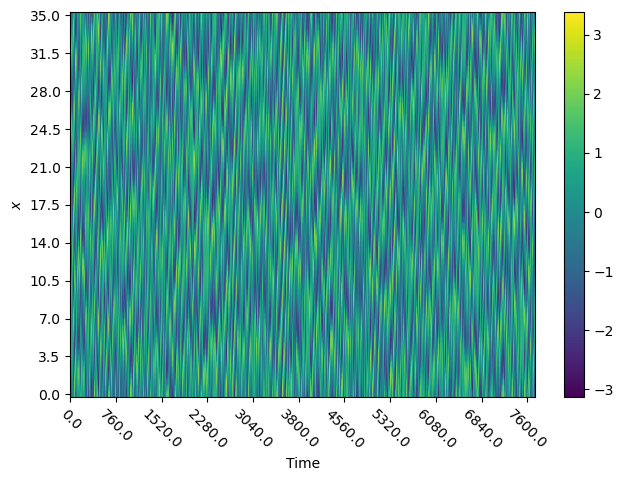

In [16]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

In [17]:
# delaing with normalizing the data before feeding into autoencoder
if normalizeforae_flag == True and use_ae_data == True:
    for i in range(numpoints_xgrid):
        all_data[:, i] -= normalization_constant_arr_aedata[0, i]
        all_data[:, i] /= normalization_constant_arr_aedata[1, i]

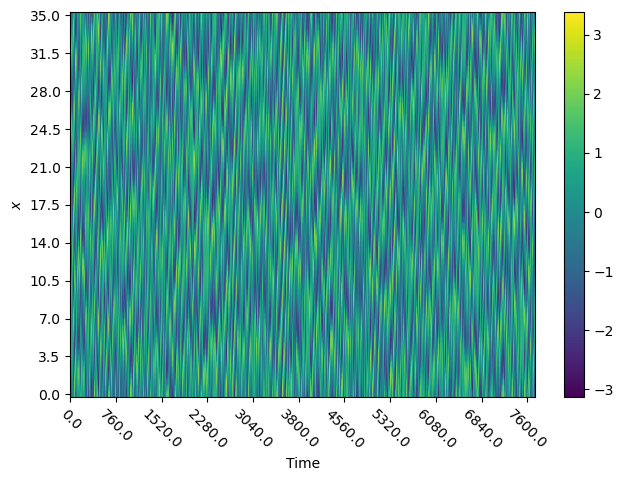

In [18]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

# Autoencoder

In [19]:
# load_file = dir_name_ae+dir_sep+'new_class_data'+dir_sep+'ae_'+ae_idx+'_class_dict.txt'
# wt_file = dir_name_ae+dir_sep+'new_class_data'+dir_sep+'ae_'+ae_idx+'_ae_weights.h5'

# if colab_flag == False:
#     dir_name_ae_og = dir_name_ae
#     dir_name_ae_temp = '/home/rkaushik/Documents/Thesis/MLROM/CDV/saved_ae/ae_'+ae_idx
#     dir_name_ae = dir_name_ae_temp

if use_ae_data == True:
    load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
    wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

# if colab_flag == False:
#     dir_name_ae = dir_name_ae_og

In [20]:
if use_ae_data == True:
    ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
    ae_net.load_weights_from_file(wt_file)

In [21]:
# create data
if use_ae_data == True:
    latent_states_all = ae_net.encoder_net.predict(all_data)
    del(all_data)
else:
    latent_states_all = all_data[:, 0:xgrid.shape[0]]
num_latent_states = latent_states_all.shape[1]

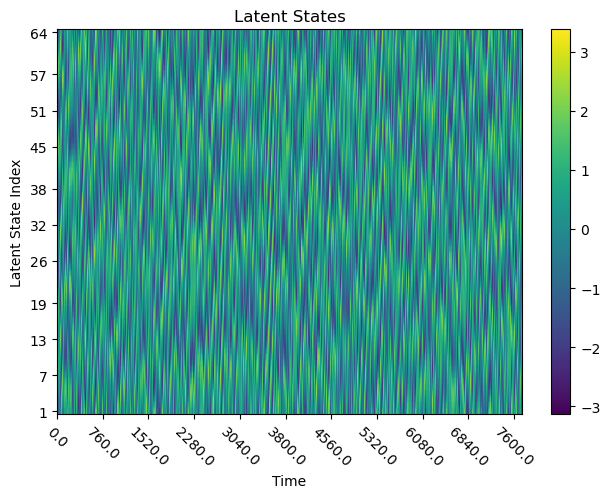

In [22]:
plot_latent_states_KS(
    boundary_idx_arr,
    latent_states_all,
    delta_t,
    dir_name_ae,
    xticks_snapto=int(40*np.round((T//10)/40)),
    num_yticks=11,
    save_figs=False)

In [23]:
# for i in range(ae_net.layers):
#     tf.keras.utils.plot_model(
#         ae_net.layers[i],
#         to_file=dir_name_ae+'/plots/netlayer_{}.png'.format(i),
#         show_shapes=True,
#         dpi=300
# )

# ESN

In [24]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    num_lyaptimesteps_totrain = 5
    dt_rnn = 0.2
    T_sample_input = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_sample_output = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_offset = dt_rnn
    normalize_dataset = True # whether the data for the RNN should be normalized by the dataset's mean and std
    normalization_arr = None
    stddev_multiplier = 3
    skip_intermediate = 1/3
    if return_params_arr != False:
        params = params_arr
    else:
        params = None
        
    timeMeanofSpaceRMS = np.mean(np.mean(latent_states_all**2, axis=1)**0.5)

    # saving simulation data
    sim_data = {
        'params_mat':params_mat,
        'init_state_mat':init_state_mat,
        't0':t0,
        'T':T,
        'delta_t':delta_t,
        'return_params_arr':return_params_arr,
        'dir_name_ae':dir_name_ae,
        'normalize_dataset':normalize_dataset,
        'stddev_multiplier':stddev_multiplier,
    }


    with open(dir_name_rnn+dir_sep+'sim_data_AE_params.txt', 'w') as f:
        f.write(str(sim_data))
        
    # saving RNN specific data
    RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        'boundary_idx_arr':boundary_idx_arr,
        'delta_t':delta_t,
        'params':params,
        'return_params_arr':return_params_arr,
        'normalize_dataset':normalize_dataset,
        'num_lyaptimesteps_totrain':num_lyaptimesteps_totrain,
        'stddev_multiplier':stddev_multiplier,
        'skip_intermediate':skip_intermediate,
        'use_ae_data':use_ae_data,
    }

    with open(dir_name_rnn+dir_sep+'RNN_specific_data.txt', 'w') as f:
        f.write(str(RNN_specific_data))

In [25]:
rnn_res_dict = create_data_for_RNN(
    latent_states_all,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    None,
    boundary_idx_arr,
    delta_t,
    params=params,
    return_numsamples=True,
    normalize_dataset=normalize_dataset,
    stddev_multiplier=stddev_multiplier,
    skip_intermediate=skip_intermediate,
    return_OrgDataIdxArr=False,
    normalization_arr_external=normalization_arr)
    
data_rnn_input = rnn_res_dict['data_rnn_input']
data_rnn_output = rnn_res_dict['data_rnn_output']
org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
num_samples = rnn_res_dict['num_samples']
normalization_arr = rnn_res_dict['normalization_arr']
rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

In [26]:
del(org_data_idx_arr_input)
del(org_data_idx_arr_output)
del(latent_states_all)

In [27]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [0.001, 0.0001, 0.00001]
    epochs = 2000
    patience = 25  # parameter for early stopping
    min_delta = 1e-6  # parameter for early stopping
    lambda_reg = 1e-4  # weight for regularizer
    train_split = 0.8
    val_split = 0.1
    test_split = 1 - train_split - val_split
    batch_size = 64
    fRMS = 0.025

    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS
    }

    with open(dir_name_rnn+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
    
    np.savez(
        dir_name_rnn+dir_sep+'normalization_data',
        normalization_arr=[normalization_arr],
    )
    
else:
    # dir_name_rnn_og = dir_name_rnn
    # dir_name_rnn_temp = '/home/rkaushik/Documents/Thesis/MLROM/CDV/saved_rnn/rnn_'+dir_name_rnn_og[-3:]
    # dir_name_rnn = dir_name_rnn_temp

    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()


    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']

    test_split = 1 - train_split - val_split

    # setting seed for PRNGs
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [28]:
# idx = np.arange(data_rnn_input.shape[0])
# np.random.shuffle(idx)
# boundary = int(np.round(train_split*data_rnn_input.shape[0]))

# training_data_rnn_input = data_rnn_input[idx[0:boundary]]
# training_data_rnn_output = data_rnn_output[idx[0:boundary]]

# testing_data_rnn_input = data_rnn_input[idx[boundary:]]
# testing_data_rnn_output = data_rnn_output[idx[boundary:]]

In [29]:
cum_samples = rnn_data_boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train = 0
num_val = 0
begin_idx = 0
for i in range(len(boundary_idx_arr)):
    num_samples = rnn_data_boundary_idx_arr[i] - begin_idx
    num_train += int( (1-test_split-val_split)*num_samples )
    num_val += int(val_split*num_samples)
    begin_idx = rnn_data_boundary_idx_arr[i]

# defining shapes
training_input_shape = [num_train]
training_input_shape.extend(data_rnn_input.shape[1:])

training_output_shape = [num_train]
training_output_shape.extend(data_rnn_output.shape[1:])

val_input_shape = [num_val]
val_input_shape.extend(data_rnn_input.shape[1:])

val_output_shape = [num_train]
val_output_shape.extend(data_rnn_output.shape[1:])

testing_input_shape = [cum_samples-num_train-num_val]
testing_input_shape.extend(data_rnn_input.shape[1:])

testing_output_shape = [cum_samples-num_train-num_val]
testing_output_shape.extend(data_rnn_output.shape[1:])

# defining required arrays
training_data_rnn_input = np.empty(shape=training_input_shape)
training_data_rnn_output = np.empty(shape=training_output_shape)

val_data_rnn_input = np.empty(shape=val_input_shape)
val_data_rnn_output = np.empty(shape=val_output_shape)

testing_data_rnn_input = np.empty(shape=testing_input_shape)
testing_data_rnn_output = np.empty(shape=testing_output_shape)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(boundary_idx_arr)):
    idx = np.arange(begin_idx, rnn_data_boundary_idx_arr[i])
    # np.random.shuffle(idx)
    num_samples = idx.shape[0]
    num_train = int( (1-test_split-val_split)*num_samples )
    num_val = int(val_split*num_samples)

    training_data_rnn_input[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_input[idx[0:num_train]]
    training_data_rnn_output[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_output[idx[0:num_train]]
    training_data_rolling_count += num_train

    val_data_rnn_input[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_input[idx[num_train:num_train+num_val]]
    val_data_rnn_output[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_output[idx[num_train:num_train+num_val]]
    val_data_rolling_count += num_val

    num_test = num_samples-num_train-num_val+1
    testing_data_rnn_input[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_input[idx[num_train+num_val:]]
    testing_data_rnn_output[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_output[idx[num_train+num_val:]]
    testing_data_rolling_count += num_test

    begin_idx = rnn_data_boundary_idx_arr[i]

# further shuffling
idx = np.arange(0, training_data_rnn_input.shape[0])
np.random.shuffle(idx)
training_data_rnn_input = training_data_rnn_input[idx]
training_data_rnn_output = training_data_rnn_output[idx]

idx = np.arange(0, val_data_rnn_input.shape[0])
np.random.shuffle(idx)
val_data_rnn_input = val_data_rnn_input[idx]
val_data_rnn_output = val_data_rnn_output[idx]

idx = np.arange(0, testing_data_rnn_input.shape[0])
np.random.shuffle(idx)
testing_data_rnn_input = testing_data_rnn_input[idx]
testing_data_rnn_output = testing_data_rnn_output[idx]

In [30]:
del(data_rnn_input)
del(data_rnn_output)

In [31]:
# timeMeanofSpaceRMS = np.mean(np.mean(latent_states_all**2, axis=1)**0.5)
stddev = fRMS*timeMeanofSpaceRMS
print('timeMeanofSpaceRMS :', timeMeanofSpaceRMS)
print('stddev :', stddev)

timeMeanofSpaceRMS : 1.2960757602294946
stddev : 0.03240189400573736


In [32]:
res_size = 2048
spectral_rad = 0.6
degree = 3
connectivity = degree / (res_size - 1.)

ESN_layer = tfa.layers.ESN(
    units=res_size,
    spectral_radius=spectral_rad,
    return_sequences=True,
    connectivity=connectivity
)
ESN_layer.trainable = False

In [33]:
training_data_rnn_input[0].shape

(387, 64)

In [34]:
ESN_input = tf.keras.Input(shape=training_data_rnn_input[0].shape)
ESN_output = tf.keras.layers.GaussianNoise(
    stddev,
    seed=prng_seed)(ESN_input)
ESN_output = ESN_layer(ESN_output)
ESN_output = tf.concat([ESN_output, tf.math.square(ESN_output)], axis=-1)
ESN_output = tf.keras.layers.TimeDistributed(
    tf.keras.layers.Dense(
        training_data_rnn_output[0].shape[-1],
        activation=None,
        kernel_regularizer=tf.keras.regularizers.L2(lambda_reg)
    )
)(ESN_output)
ESN_model = Model(ESN_input, ESN_output)

In [35]:
if behaviour == 'initialiseAndTrainFromScratch':
    val_loss_hist = []
    train_loss_hist = []
    lr_change=[0, 0]
    savelosses_cb_vallossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    savelosses_cb_trainlossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    starting_lr_idx = 0
    num_epochs_left = epochs
    earlystopping_wait = 0
elif behaviour == 'loadCheckpointAndContinueTraining':
    val_loss_hist, train_loss_hist, lr_change, starting_lr_idx, num_epochs_left, val_loss_arr_fromckpt, train_loss_arr_fromckpt, earlystopping_wait = readAndReturnLossHistories(
        dir_name_ae=dir_name_rnn,
        dir_sep=dir_sep,
        epochs=epochs,
        learning_rate_list=learning_rate_list,
        return_earlystopping_wait=True)
    savelosses_cb_vallossarr = val_loss_arr_fromckpt
    savelosses_cb_trainlossarr = train_loss_arr_fromckpt
elif behaviour == 'loadFinalNetAndPlot':
    with open(dir_name_rnn+'{ds}final_net{ds}losses.txt'.format(ds=dir_sep), 'r') as f:
        lines = f.readlines()
    
    losses_dict = eval(''.join(lines))

    val_loss_hist = losses_dict['val_loss_hist']
    train_loss_hist = losses_dict['train_loss_hist']
    lr_change = losses_dict['lr_change']
    test_loss = losses_dict['test_loss']

In [36]:
# compiling the network
ESN_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_list[0]),
    loss=losses.MeanSquaredError(),
    run_eagerly=False
)

if behaviour == 'loadCheckpointAndContinueTraining':
    # this loads the weights/attributes of the optimizer as well
    if strategy is not None:
        with strategy.scope():
            ESN_model.load_weights(wt_file)
    else:
        ESN_model.load_weights(wt_file)

if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    # implementing early stopping
    baseline = None
    if behaviour == 'loadCheckpointAndContinueTraining':
        baseline = np.min(val_loss_hist)
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True,
        verbose=True,
        min_delta=min_delta,
        baseline=baseline
    )
    #** the two lines below are useless because wait is set to 0 in on_train_begin
    # early_stopping_cb.wait = earlystopping_wait
    # print('early_stopping_cb.wait : {}\n'.format(early_stopping_cb.wait))

    # time callback for each epoch
    timekeeper_cb = mytimecallback()

    # model checkpoint callback
    dir_name_ckpt = dir_name_rnn+dir_sep+'checkpoints'
    if not os.path.isdir(dir_name_ckpt):
        os.makedirs(dir_name_ckpt)
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=dir_name_ckpt+dir_sep+'checkpoint',#+'/checkpoint--loss={loss:.4f}--vall_loss={val_loss:.4f}',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        verbose=2,
        initial_value_threshold=baseline,
        period=1  # saves every `period` epochs
    )

    # save losses callback
    savelosses_cb = SaveLosses(
        filepath=dir_name_ckpt+dir_sep+'LossHistoriesCheckpoint',
        val_loss_arr=savelosses_cb_vallossarr,
        train_loss_arr=savelosses_cb_trainlossarr,
        total_epochs=epochs,
        period=1)

    for i in range(starting_lr_idx, len(learning_rate_list)):
        learning_rate = learning_rate_list[i]
        K.set_value(ESN_model.optimizer.lr, learning_rate)

        savelosses_cb.update_lr_idx(i)

        if i == starting_lr_idx:
            EPOCHS = num_epochs_left
            savelosses_cb.update_offset(epochs-num_epochs_left)
        else:
            EPOCHS = epochs
            savelosses_cb.update_offset(0)

        total_s_len = 80
        sep_lr_s = ' LEARNING RATE : {} '.format(learning_rate)
        sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'-' + sep_lr_s
        sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'-'
        print('\n\n' + '-'*len(sep_lr_s))
        print('\n' + sep_lr_s+'\n')
        print('-'*len(sep_lr_s) + '\n\n')
        
        history = ESN_model.fit(training_data_rnn_input, training_data_rnn_output,
            epochs=EPOCHS,
            batch_size=batch_size,
#             validation_split=val_split/train_split,
            validation_data=(val_data_rnn_input, val_data_rnn_output),
            callbacks=[early_stopping_cb, timekeeper_cb, checkpoint_cb, savelosses_cb],
            verbose=1
        )

        val_loss_hist.extend(history.history['val_loss'])
        train_loss_hist.extend(history.history['loss'])
        
        if i == starting_lr_idx:
            lr_change[i+1] += len(history.history['val_loss'])
        else:
            lr_change.append(lr_change[i]+len(history.history['val_loss']))



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/2000
4/4 [==============================] - ETA: 0s - loss: 0.0920 - tot_time: 0h 0m 3.8s

Epoch 1: val_loss improved from inf to 0.04294, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_030/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 4s 796ms/step - loss: 0.0920 - val_loss: 0.0429
Epoch 2/2000
4/4 [==============================] - ETA: 0s - loss: 0.0340 - tot_time: 0h 0m 6.6s

Epoch 2: val_loss improved from 0.04294 to 0.02676, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Docu

Epoch 18/2000
4/4 [==============================] - ETA: 0s - loss: 0.0061 - tot_time: 0h 0m 51.9s

Epoch 18: val_loss improved from 0.00602 to 0.00584, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_030/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 3s 742ms/step - loss: 0.0061 - val_loss: 0.0058
Epoch 19/2000
4/4 [==============================] - ETA: 0s - loss: 0.0059 - tot_time: 0h 0m 54.7s

Epoch 19: val_loss improved from 0.00584 to 0.00567, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_030/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 3s 744ms/step - loss: 0.0059 - val_loss: 0.0057
Epoch 20/2000
4/4 [==============================] - ETA: 0s - loss: 0.0058 

Epoch 36/2000
4/4 [==============================] - ETA: 0s - loss: 0.0038 - tot_time: 0h 1m 42.6s

Epoch 36: val_loss improved from 0.00370 to 0.00360, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_030/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 3s 749ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 37/2000
4/4 [==============================] - ETA: 0s - loss: 0.0037 - tot_time: 0h 1m 45.4s

Epoch 37: val_loss improved from 0.00360 to 0.00352, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_030/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 3s 747ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 38/2000
4/4 [==============================] - ETA: 0s - loss: 0.0036 

Epoch 54/2000
4/4 [==============================] - ETA: 0s - loss: 0.0026 - tot_time: 0h 2m 33.6s

Epoch 54: val_loss improved from 0.00244 to 0.00239, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_030/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 3s 744ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 55/2000
4/4 [==============================] - ETA: 0s - loss: 0.0025 - tot_time: 0h 2m 36.4s

Epoch 55: val_loss improved from 0.00239 to 0.00235, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_030/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 3s 753ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 56/2000
4/4 [==============================] - ETA: 0s - loss: 0.0025 

Epoch 72/2000
4/4 [==============================] - ETA: 0s - loss: 0.0019 - tot_time: 0h 3m 24.4s

Epoch 72: val_loss improved from 0.00179 to 0.00177, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_030/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 3s 761ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 73/2000
4/4 [==============================] - ETA: 0s - loss: 0.0019 - tot_time: 0h 3m 27.3s

Epoch 73: val_loss improved from 0.00177 to 0.00174, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_030/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 3s 753ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 74/2000
4/4 [==============================] - ETA: 0s - loss: 0.0019 

Epoch 90/2000
4/4 [==============================] - ETA: 0s - loss: 0.0016 - tot_time: 0h 4m 15.0s

Epoch 90: val_loss improved from 0.00147 to 0.00146, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_030/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 3s 753ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 91/2000
4/4 [==============================] - ETA: 0s - loss: 0.0016 - tot_time: 0h 4m 17.9s

Epoch 91: val_loss improved from 0.00146 to 0.00144, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_030/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 3s 763ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 92/2000
4/4 [==============================] - ETA: 0s - loss: 0.0016 

Epoch 108/2000
4/4 [==============================] - ETA: 0s - loss: 0.0015 - tot_time: 0h 5m 6.0s

Epoch 108: val_loss improved from 0.00131 to 0.00130, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_030/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 3s 755ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 109/2000
4/4 [==============================] - ETA: 0s - loss: 0.0015 - tot_time: 0h 5m 8.8s

Epoch 109: val_loss improved from 0.00130 to 0.00130, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_030/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 3s 742ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 110/2000
4/4 [==============================] - ETA: 0s - loss: 0.00

Epoch 126/2000
4/4 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 5m 56.7s

Epoch 126: val_loss improved from 0.00123 to 0.00123, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_030/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 3s 747ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 127/2000
4/4 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 5m 59.5s

Epoch 127: val_loss improved from 0.00123 to 0.00122, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_030/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 3s 748ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 128/2000
4/4 [==============================] - ETA: 0s - loss: 0.

Epoch 144/2000
4/4 [==============================] - ETA: 0s - loss: 0.0013 - tot_time: 0h 6m 47.2s

Epoch 144: val_loss improved from 0.00119 to 0.00119, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_030/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 3s 729ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 145/2000
4/4 [==============================] - ETA: 0s - loss: 0.0013 - tot_time: 0h 6m 49.9s

Epoch 145: val_loss improved from 0.00119 to 0.00118, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_030/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 3s 735ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 146/2000
4/4 [==============================] - ETA: 0s - loss: 0.

Epoch 163/2000
4/4 [==============================] - ETA: 0s - loss: 0.0013 - tot_time: 0h 7m 40.2s

Epoch 163: val_loss improved from 0.00117 to 0.00117, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_030/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 3s 759ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 164/2000
4/4 [==============================] - ETA: 0s - loss: 0.0013 - tot_time: 0h 7m 43.1s

Epoch 164: val_loss did not improve from 0.00117
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_030/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 3s 706ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 165/2000
4/4 [==============================] - ETA: 0s - loss: 0.0013 - tot_time: 0h 7m 45.8s

Epoch 165: val_loss did not improve from 0.00117
 - saving loss histories

Epoch 184/2000
4/4 [==============================] - ETA: 0s - loss: 0.0013 - tot_time: 0h 8m 37.9s

Epoch 184: val_loss did not improve from 0.00116
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_030/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 3s 699ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 185/2000
4/4 [==============================] - ETA: 0s - loss: 0.0013 - tot_time: 0h 8m 40.6s

Epoch 185: val_loss did not improve from 0.00116
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_030/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 3s 709ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 186/2000
4/4 [==============================] - ETA: 0s - loss: 0.0013 - tot_time: 0h 8m 43.3s

Epoch 186: val_loss did not improve from 0.00116
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_030/checkpoints/LossHistoriesCheckpoint
4/4 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_030/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 3s 701ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 206/2000
4/4 [==============================] - ETA: 0s - loss: 0.0013 - tot_time: 0h 9m 37.7s

Epoch 206: val_loss did not improve from 0.00115
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_030/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 3s 702ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 207/2000
4/4 [==============================] - ETA: 0s - loss: 0.0013 - tot_time: 0h 9m 40.4s

Epoch 207: val_loss did not improve from 0.00115
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_030/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 3s 707ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 208/2000
4/4 [==============================] - ETA: 0s - loss

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_030/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 3s 711ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 228/2000
4/4 [==============================] - ETA: 0s - loss: 0.0013 - tot_time: 0h 10m 37.3s

Epoch 228: val_loss did not improve from 0.00115
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_030/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 3s 701ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 229/2000
4/4 [==============================] - ETA: 0s - loss: 0.0013 - tot_time: 0h 10m 40.0s

Epoch 229: val_loss did not improve from 0.00115
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_030/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 3s 706ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 230/2000
4/4 [==============================] - ETA: 0s - lo

Epoch 249: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.0001 ----------------------------

--------------------------------------------------------------------------------


Epoch 1/2000
4/4 [==============================] - ETA: 0s - loss: 0.0013 - tot_time: 0h 11m 36.3s

Epoch 1: val_loss improved from 0.00115 to 0.00115, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_030/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 3s 774ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 2/2000
4/4 [==============================] - ETA: 0s - loss: 0.0013 - tot_time: 0h 11m 39.1s

Epoch 2: val_loss did not improve from 0.00115
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_030/checkpoints/LossHistoriesChec

Epoch 22/2000
4/4 [==============================] - ETA: 0s - loss: 0.0013 - tot_time: 0h 12m 33.0s

Epoch 22: val_loss did not improve from 0.00115
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_030/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 3s 704ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 23/2000
4/4 [==============================] - ETA: 0s - loss: 0.0013 - tot_time: 0h 12m 35.7s

Epoch 23: val_loss did not improve from 0.00115
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_030/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 3s 697ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 24/2000
4/4 [==============================] - ETA: 0s - loss: 0.0013 - tot_time: 0h 12m 38.4s

Epoch 24: val_loss did not improve from 0.00115
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_030/checkpoints/LossHistoriesCheckpoint
4/4 [==

Epoch 14/2000
4/4 [==============================] - ETA: 0s - loss: 0.0013 - tot_time: 0h 13m 32.2s

Epoch 14: val_loss did not improve from 0.00115
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_030/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 3s 700ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 15/2000
4/4 [==============================] - ETA: 0s - loss: 0.0013 - tot_time: 0h 13m 34.8s

Epoch 15: val_loss did not improve from 0.00115
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_030/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 3s 702ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 16/2000
4/4 [==============================] - ETA: 0s - loss: 0.0013 - tot_time: 0h 13m 37.5s

Epoch 16: val_loss did not improve from 0.00115
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_030/checkpoints/LossHistoriesCheckpoint
4/4 [==

In [37]:
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    test_loss = ESN_model.evaluate(
        testing_data_rnn_input, testing_data_rnn_output,
    )

    save_path = dir_name_rnn+dir_sep+'final_net'

    if not os.path.isdir(save_path):
        os.makedirs(save_path)


    with open(save_path+dir_sep+'losses.txt', 'w') as f:
        f.write(str({
            'val_loss_hist':val_loss_hist,
            'train_loss_hist':train_loss_hist,
            'lr_change':lr_change,
            'test_loss':test_loss
        }))
        
    if normalize_dataset == True:
        with open(save_path+dir_sep+'rnn_normalization.txt', 'w') as f:
            f.write(str({
                'normalization_arr':normalization_arr
            }))

    ESN_model.save_weights(
        save_path+dir_sep+'final_net.h5')

1/1 [==============================] - 0s 420ms/step - loss: 0.0011


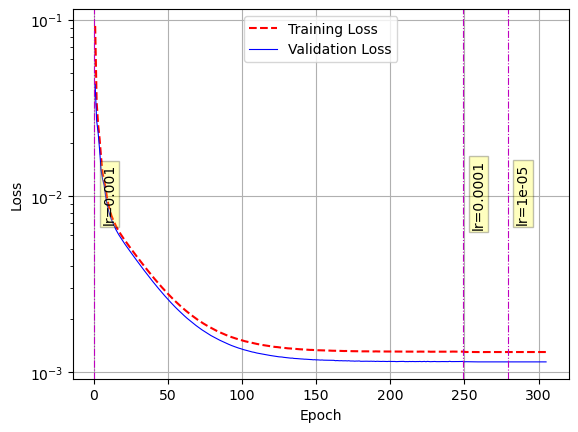

In [38]:
# plotting losses
dir_name_plot = dir_name_rnn+dir_sep+'plots'
if not os.path.isdir(dir_name_plot):
    os.makedirs(dir_name_plot)

# Visualize loss history
fig, ax = plot_losses(
    training_loss=train_loss_hist,
    val_loss=val_loss_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list
)

plt.savefig(dir_name_rnn+'{ds}plots{ds}loss_history.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')
plt.show()


data_idx : 26


Text(0.5, 1.0, 'Latent States')

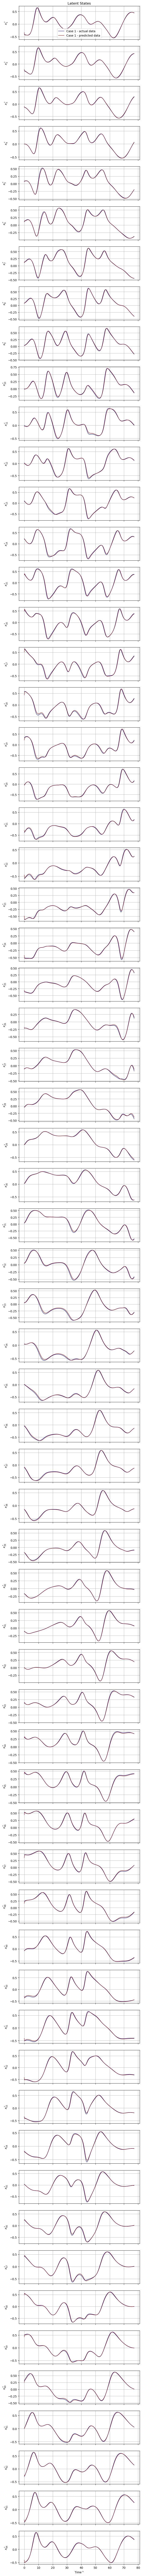

In [39]:
# data_type = 'training'
data_type = 'testing'

data_in = eval(data_type+'_data_rnn_input')
data_out = eval(data_type+'_data_rnn_output')

data_idx = np.arange(data_in.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
print('data_idx : {}'.format(data_idx))

# data_in = data_in[data_idx]
data_out = data_out[data_idx]

prediction = ESN_model.predict(data_in[data_idx:data_idx+1, :, :])

n = 1
num_latent_states = data_out.shape[-1]
N = data_out.shape[0]

num_cols = 1
num_rows = n*num_latent_states

ax_ylabels = [r'$x^*_{'+str(i+1)+'}$' for i in range(num_latent_states)]

fig, ax = plt.subplots(num_latent_states, 1, sharex=True, figsize=(7.5*num_cols, 2.5*num_rows))
if num_latent_states == 1:
    ax = [ax]
input_time = np.arange(0, N)*dt_rnn

cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, 2*n)]

prev_idx = 0

mpl_ax_artist_list = []
for j in range(num_latent_states):
    for i in range(n):
        obj_in = ax[j].plot(input_time, data_out[:, j], linewidth=1, color=colors[2*i], label='Case {} - actual data'.format(i+1))
        obj_out = ax[j].plot(input_time, prediction[0, :, j], linewidth=1, color=colors[2*i+1], label='Case {} - predicted data'.format(i+1))
        mpl_ax_artist_list.append(obj_in[0])
        mpl_ax_artist_list.append(obj_out[0])
    ax[j].set_ylabel(ax_ylabels[j])
    # if xlim is not None:
    #     ax[j].set_xlim(xlim)
    # if ylim is not None:
    #     ax[j].set_ylim(ylim)
    ax[j].grid(True)
    ax[j].set_axisbelow(True)


ax[-1].set_xlabel('Time$^+$')

max_rows = 10
max_rows = float(max_rows)
ncols = int(np.ceil(len(boundary_idx_arr) / max_rows))
# plt.figlegend(
#     handles=mpl_ax_artist_list[0:n],
#     # bbox_to_anchor=[1.1,0.85],
#     loc=legend_loc,
#     bbox_to_anchor=legend_bbox_to_anchor,
#     ncol=ncols,
#     markerscale=legend_markerscale
# )
ax[0].legend(
    # handles=mpl_ax_artist_list[0:n],
    # bbox_to_anchor=[1.1,0.85],
    loc='best',
    # bbox_to_anchor=legend_bbox_to_anchor,
    ncol=ncols,
    # markerscale=legend_markerscale
)
# fig.suptitle(r'Latent States', size=12)
ax[0].set_title(r'Latent States', size=12)

data_idx : 1


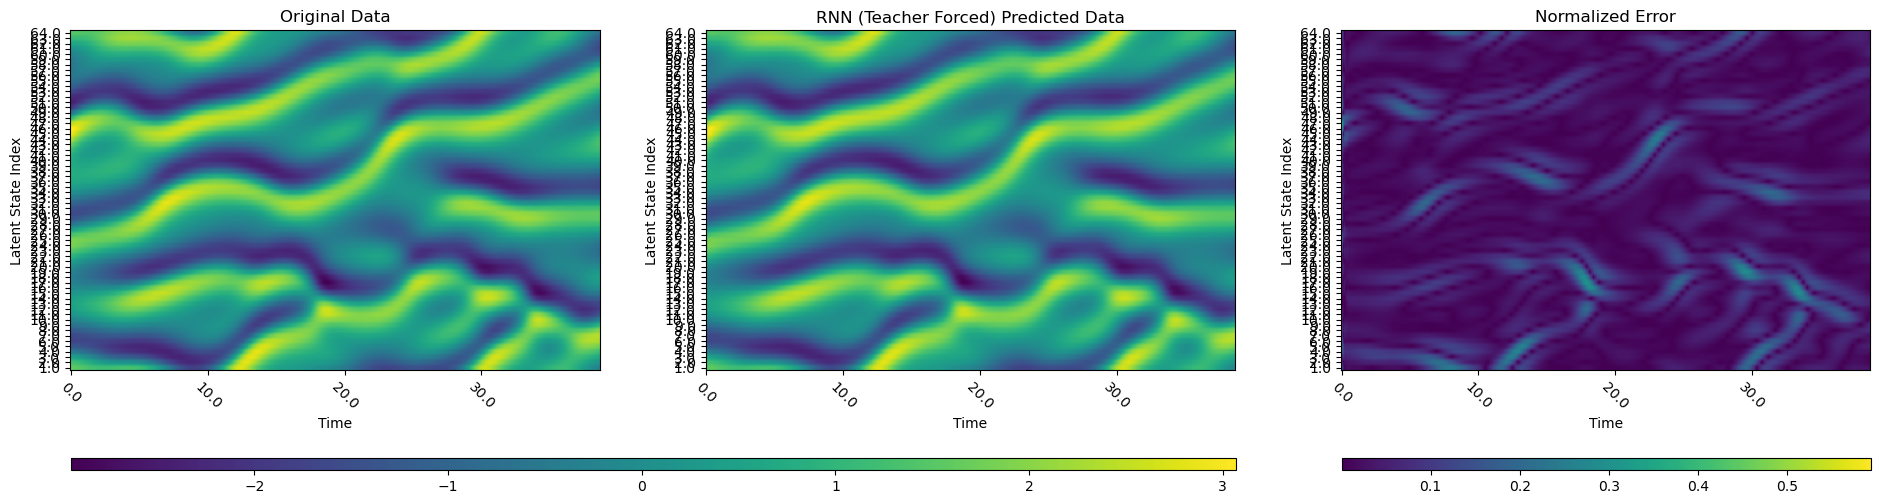

In [40]:
# data_type = 'training'
data_type = 'testing'

data_in = eval(data_type+'_data_rnn_input')
data_out = eval(data_type+'_data_rnn_output')

data_idx = np.arange(data_in.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
# data_idx = 3788
print('data_idx : {}'.format(data_idx))

# data_in = data_in[data_idx]
data_out = data_out[data_idx]

prediction = ESN_model.predict(data_in[data_idx:data_idx+1, :, :])

plot_reconstructed_data_KS(
    [data_out.shape[0]],
    dir_name_ae,
    data_out,
    prediction[0], delta_t, 1+np.arange(0, data_out.shape[1]),
    save_figs=False,
    normalization_constant_arr=normalization_arr,
    xticks_snapto=int(10*np.round((T_sample_output//10)/10)),
    num_yticks=data_out.shape[1],
    ylabel=r'Latent State Index',
    ax1_title=r'Original Data',
    ax2_title=r'RNN (Teacher Forced) Predicted Data')

data_idx : 22


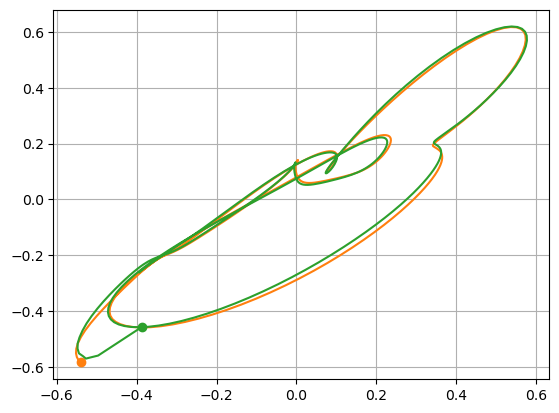

In [41]:
# data_type = 'training'
data_type = 'testing'

data_in = eval(data_type+'_data_rnn_input')
data_out = eval(data_type+'_data_rnn_output')

data_idx = np.arange(data_in.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
# data_idx = 10
print('data_idx : {}'.format(data_idx))

### initial point
# plt.plot(data_in[data_idx, :, 0], data_in[data_idx, :, 1], 'o')

### actual trajectory
plt.plot(data_out[data_idx, 0, 0], data_out[data_idx, 0, 1], 'o', color='C1')
plt.plot(data_out[data_idx, :, 0], data_out[data_idx, :, 1], 'C1')

### predicted trajectory
prediction = ESN_model.predict(data_in[data_idx:data_idx+1, :, :])
# plt.plot([data_in[data_idx, :, 0], ].extend(prediction[0, :, 0]), [data_in[data_idx, :, 1], ].extend(prediction[0, :, 1]))
plt.plot(prediction[0, :, 0], prediction[0, :, 1], color='C2')
plt.plot(prediction[0, 0, 0], prediction[0, 0, 1], 'o', color='C2')

plt.grid(True)
plt.show()

# AutoRegressive ESN

In [42]:
num_input_timesteps = 121
num_output_timesteps = training_data_rnn_output.shape[1] - num_input_timesteps

In [43]:
AR_ESN_layer = tfa.layers.ESN(
    units=res_size,
    spectral_radius=spectral_rad,
    return_sequences=False,
    connectivity=connectivity
)
AR_ESN_layer.trainable = False
AR_ESN_layer.return_state = True

In [44]:
AR_ESN_input = tf.keras.Input(shape=training_data_rnn_input[0, 0:1].shape)
AR_ESN_output, ESN_state = AR_ESN_layer(AR_ESN_input)
AR_ESN_output = tf.concat([AR_ESN_output, tf.math.square(AR_ESN_output)], axis=-1)
AR_ESN_output = tf.keras.layers.Dense(
        training_data_rnn_input[0, 0:1].shape[-1],
        activation=None,
        kernel_regularizer=tf.keras.regularizers.L2(lambda_reg)
)(AR_ESN_output)
AR_ESN_model = Model(AR_ESN_input, [AR_ESN_output, ESN_state])

In [45]:
AR_ESN_model.set_weights(ESN_model.get_weights())

In [46]:
AR_ESN_layer.states

[None]

In [47]:
og_get_initial_state = AR_ESN_model.layers[1].cell.get_initial_state

In [48]:
# AR_ESN_model.layers[1].return_state = True

In [49]:
AR_ESN_model.output

[<KerasTensor: shape=(None, 64) dtype=float32 (created by layer 'dense_1')>,
 <KerasTensor: shape=(None, 2048) dtype=float32 (created by layer 'esn_1')>]

data_idx : 30
data_out.shape : (266, 64)


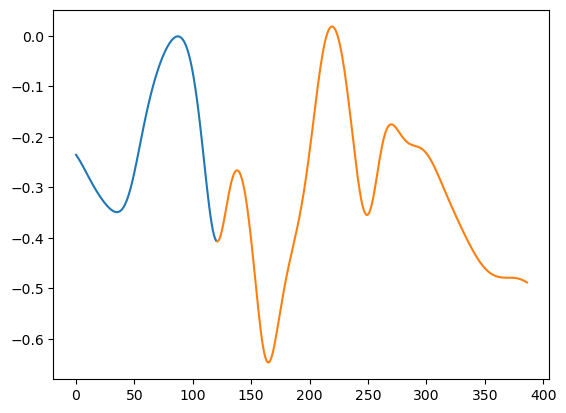

In [50]:
# data_type = 'training'
data_type = 'testing'

data_in = eval(data_type+'_data_rnn_input')
data_out = eval(data_type+'_data_rnn_output')

data_idx = np.arange(data_in.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
# data_idx = 0
print('data_idx : {}'.format(data_idx))
data_out = data_out[data_idx, num_input_timesteps-1:num_input_timesteps-1+num_output_timesteps]
print('data_out.shape :', data_out.shape)

plt.plot(data_in[data_idx, 0:num_input_timesteps, 0])
plt.plot(np.arange(data_out.shape[0])+num_input_timesteps, data_out[:, 0])
plt.show()

In [51]:
prediction_lst = []
input_pred_lst = []
# print('\ni=0 : state = ', AR_ESN_model.layers[1].states)
AR_ESN_model.layers[1].cell.get_initial_state = og_get_initial_state
prediction, state = AR_ESN_model(data_in[data_idx:data_idx+1, 0:1, :], training=None)
# state = AR_ESN_model.layers[1].states
input_pred_lst.append(prediction)
# print('i=0 : state = ', state)
# print('')
print(data_in[data_idx:data_idx+1, 0:1, :].shape)



for i in range(1, num_input_timesteps):
#     AR_ESN_model.layers[1].states = state
#     print('\ni={} : state = '.format(i), state)
    AR_ESN_model.layers[1].cell.get_initial_state = lambda **kwargs:state
    prediction, state = AR_ESN_model(data_in[data_idx:data_idx+1, i:i+1, :], training=None)#, state=state)
#     state = AR_ESN_model.layers[1].states
    input_pred_lst.append(prediction)
#     print('i={} : state = '.format(i), AR_ESN_model.layers[1].states)
#     print('')
input_pred_lst = tf.stack(input_pred_lst)
input_pred_lst = tf.transpose(input_pred_lst, [1, 0, 2])
print(input_pred_lst.shape)

prediction_lst.append(prediction)
for i in range(1, num_output_timesteps):
#     AR_ESN_model.layers[1].states = state
    AR_ESN_model.layers[1].cell.get_initial_state = lambda **kwargs:state
    prediction, state = AR_ESN_model(tf.stack([prediction]), training=None)#, state=state)
#     state = AR_ESN_model.layers[1].states
    prediction_lst.append(prediction)
    
predictions = tf.stack(prediction_lst)
prediction = tf.transpose(predictions, [1, 0, 2])

(1, 1, 64)
(1, 121, 64)


In [52]:
print('input_pred_lst.shape', input_pred_lst.shape)
print('prediction.shape', prediction.shape)

input_pred_lst.shape (1, 121, 64)
prediction.shape (1, 266, 64)


(266, 64)
(1, 266, 64)


Text(0.5, 1.0, 'Latent States')

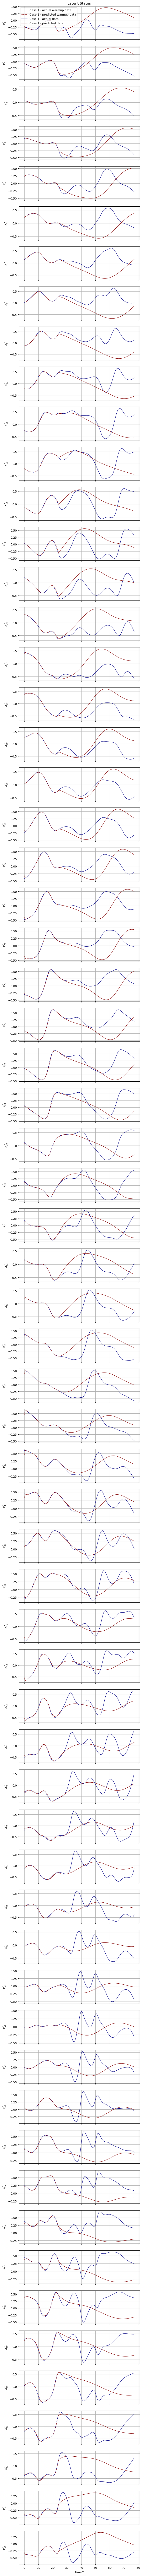

In [53]:
n = 1
num_latent_states = data_out.shape[-1]
N = data_out.shape[0]#num_output_timesteps
print(data_out.shape)
print(prediction.shape)

num_cols = 1
num_rows = n*num_latent_states

ax_ylabels = [r'$x^*_{'+str(i+1)+'}$' for i in range(num_latent_states)]

fig, ax = plt.subplots(num_latent_states, 1, sharex=True, figsize=(7.5*num_cols, 2.5*num_rows))
if num_latent_states == 1:
    ax = [ax]
input_time = np.arange(input_pred_lst.shape[1], input_pred_lst.shape[1]+N)*dt_rnn

cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, 2*n)]

prev_idx = 0

time_arr_warmup = np.arange(0, input_pred_lst.shape[1])*dt_rnn

for j in range(num_latent_states):
    for i in range(n):
        ax[j].plot(time_arr_warmup, data_in[data_idx, 0:num_input_timesteps, j], linestyle='--', linewidth=1, color=colors[2*i], label='Case {} - actual warmup data'.format(i+1))
        ax[j].plot(time_arr_warmup+dt_rnn, input_pred_lst[0, :, j], linestyle='--', linewidth=1, color=colors[2*i+1], label='Case {} - predicted warmup data'.format(i+1))
        ax[j].plot(input_time, data_out[:, j], linewidth=1, color=colors[2*i], label='Case {} - actual data'.format(i+1))
        ax[j].plot(input_time, prediction[0, :, j], linewidth=1, color=colors[2*i+1], label='Case {} - predicted data'.format(i+1))
    ax[j].set_ylabel(ax_ylabels[j])
    ax[j].grid(True)
    ax[j].set_axisbelow(True)


ax[-1].set_xlabel('Time$^+$')

max_rows = 10
max_rows = float(max_rows)
ncols = int(np.ceil(len(boundary_idx_arr) / max_rows))
ax[0].legend(
    loc='best',
    ncol=ncols,
)
ax[0].set_title(r'Latent States', size=12)

In [54]:
training_data_rnn_input[0, 0].shape

(64,)

In [55]:
data_out[data_idx].shape

(64,)